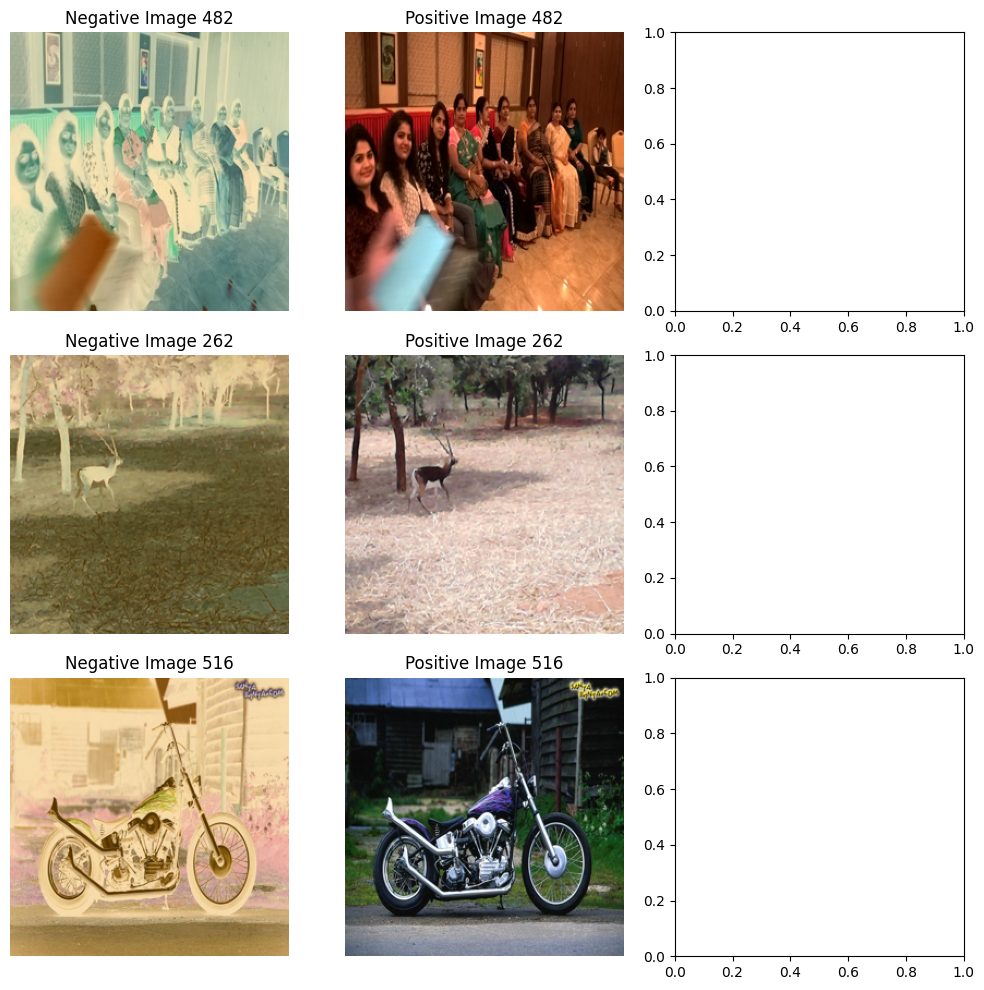

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to denormalize images from [-1, 1] to [0, 1]
def denormalize(image):
    return (image + 1) / 2.0

# Randomly select two indices
random_indices = random.sample(range(min(len(negative_images), len(positive_images))), 3)

# Plot the selected pairs
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, idx in enumerate(random_indices):
    # Get the images
    negative_image = negative_images[idx]
    positive_image = positive_images[idx]

    # Denormalize images
    negative_image = denormalize(negative_image)
    positive_image = denormalize(positive_image)

    # Display the images
    axes[i, 0].imshow(negative_image)
    axes[i, 0].set_title(f"Negative Image {idx}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(positive_image)
    axes[i, 1].set_title(f"Positive Image {idx}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [3]:
!pip install matplotlib

     |████████████████████████████████| 7.8 MB 3.0 MB/s eta 0:00:01
  Using cached contourpy-1.2.1-cp39-cp39-macosx_11_0_arm64.whl (244 kB)
  Using cached fonttools-4.53.1-cp39-cp39-macosx_11_0_arm64.whl (2.2 MB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl (38 kB)
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl (66 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
You should consider upgrading via the '/Users/satyasusarla/code/CNN-Project/code/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import os
import numpy as np
from PIL import Image, ImageFile
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# To handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to load and sort images
def load_images_sorted(image_paths):
    images = []
    image_paths_sorted = sorted(image_paths)
    for image_path in image_paths_sorted:
        try:
            img = Image.open(image_path).convert('RGB')
            img = img.resize((256, 256))
            img_array = img_to_array(img)
            img_array = (img_array / 127.5) - 1  # Normalize to [-1, 1]
            images.append(img_array)
        except (OSError, ValueError) as e:
            print(f"Error loading image {image_path}: {e}")
            continue
    return np.array(images)

# Paths to your datasets
negative_images_path = '/Users/satyasusarla/code/CNN-Project/Final-Photos/*.png'
positive_images_path = '/Users/satyasusarla/code/CNN-Project/Data-Photos/*.jpg'

# Load and sort images
negative_image_files = sorted(glob(negative_images_path))
positive_image_files = sorted(glob(positive_images_path))

negative_images = load_images_sorted(negative_image_files)
positive_images = load_images_sorted(positive_image_files)

# Check shapes
print(f'Negative images shape: {negative_images.shape}')
print(f'Positive images shape: {positive_images.shape}')

/Users/satyasusarla/code/CNN-Project/code/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Negative images shape: (532, 256, 256, 3)
Positive images shape: (532, 256, 256, 3)


In [5]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Concatenate
from tensorflow.keras.models import Model

def build_generator():
    def conv_block(x, filters, batch_norm=True):
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def deconv_block(x, skip_input, filters, dropout_rate=0):
        x = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
        x = Concatenate()([x, skip_input])
        x = LeakyReLU(alpha=0.2)(x)
        return x

    inputs = Input(shape=[256, 256, 3])
    e1 = conv_block(inputs, 64, batch_norm=False)
    e2 = conv_block(e1, 128)
    e3 = conv_block(e2, 256)
    e4 = conv_block(e3, 512)
    e5 = conv_block(e4, 512)
    e6 = conv_block(e5, 512)
    e7 = conv_block(e6, 512)
    e8 = conv_block(e7, 512, batch_norm=False)

    d1 = deconv_block(e8, e7, 512, dropout_rate=0.5)
    d2 = deconv_block(d1, e6, 512, dropout_rate=0.5)
    d3 = deconv_block(d2, e5, 512, dropout_rate=0.5)
    d4 = deconv_block(d3, e4, 512)
    d5 = deconv_block(d4, e3, 256)
    d6 = deconv_block(d5, e2, 128)
    d7 = deconv_block(d6, e1, 64)
    d8 = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(d7)

    return Model(inputs, d8)

generator = build_generator()
generator.summary()


/Users/satyasusarla/code/CNN-Project/code/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 54,429,315 (207.63 MB)

 Trainable params: 54,419,459 (207.59 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [6]:
def build_discriminator():
    def d_layer(x, filters, batch_norm=True):
        x = Conv2D(filters, kernel_size=4, strides=2, padding='same')(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    input_img = Input(shape=[256, 256, 3])
    target_img = Input(shape=[256, 256, 3])
    combined_imgs = Concatenate()([input_img, target_img])

    d1 = d_layer(combined_imgs, 64, batch_norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)
    d5 = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([input_img, target_img], d5)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 6)                │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,208 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    131,200 │ leaky_re_lu_15[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_16[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_17[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16, 1) │      8,193 │ leaky_re_lu_18[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,771,393 (10.57 MB)

 Trainable params: 2,769,601 (10.57 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [7]:
import datetime

# Loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, generated_image], training=True)

        gen_loss = generator_loss(disc_generated_output, generated_image, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_images(model, test_input, tar, epoch):
    prediction = model(test_input, training=False)
    prediction_img = array_to_img(prediction[0])
    prediction_img.save(f'/Users/satyasusarla/code/CNN-Project/epoch_{epoch}_output.jpg')

# Training loop
EPOCHS = 80
BATCH_SIZE = 1
buffer_size = len(negative_images)

# Create output directory if it doesn't exist
if not os.path.exists('/Users/satyasusarla/code/CNN-Project/output'):
    os.makedirs('/Users/satyasusarla/code/CNN-Project/output')

# Create model directory if it doesn't exist
if not os.path.exists('/Users/satyasusarla/code/CNN-Project/models'):
    os.makedirs('/Users/satyasusarla/code/CNN-Project/models')

for epoch in range(EPOCHS):
    start = datetime.datetime.now()

    for i in range(buffer_size // BATCH_SIZE):
        input_image = negative_images[i:i + BATCH_SIZE]
        target_image = positive_images[i:i + BATCH_SIZE]
        gen_loss, disc_loss = train_step(input_image, target_image)

    if (epoch + 1) % 10 == 0:
        generate_images(generator, negative_images[:1], positive_images[:1], epoch + 1)

    if (epoch + 1) % 20 == 0:
        generator.save(f'/Users/satyasusarla/code/CNN-Project/generator_epoch_{epoch + 1}.h5')
        discriminator.save(f'/Users/satyasusarla/code/CNN-Project/discriminator_epoch_{epoch + 1}.h5')

    print(f'Epoch {epoch + 1}/{EPOCHS}, Time: {datetime.datetime.now() - start}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')


Epoch 1/80, Time: 0:09:10.704560, Generator Loss: 41.659767150878906, Discriminator Loss: 1.7784967422485352
Epoch 2/80, Time: 0:08:23.126093, Generator Loss: 40.41704559326172, Discriminator Loss: 0.6482970118522644
Epoch 3/80, Time: 0:08:08.866844, Generator Loss: 38.178279876708984, Discriminator Loss: 0.6304520964622498
Epoch 4/80, Time: 0:08:20.534444, Generator Loss: 46.517093658447266, Discriminator Loss: 0.89780592918396
Epoch 5/80, Time: 0:07:46.754150, Generator Loss: 48.43497085571289, Discriminator Loss: 0.6655341982841492
Epoch 6/80, Time: 0:07:04.106264, Generator Loss: 48.834693908691406, Discriminator Loss: 0.7157710790634155
Epoch 7/80, Time: 0:07:37.117786, Generator Loss: 51.00133514404297, Discriminator Loss: 0.5650005340576172
Epoch 8/80, Time: 0:08:18.538279, Generator Loss: 49.01142883300781, Discriminator Loss: 1.2845503091812134
Epoch 9/80, Time: 0:08:31.808342, Generator Loss: 45.9682731628418, Discriminator Loss: 1.5219712257385254
Epoch 10/80, Time: 0:08:30.

Epoch 20/80, Time: 0:03:31.436811, Generator Loss: 30.092790603637695, Discriminator Loss: 1.632323145866394
Epoch 21/80, Time: 0:03:32.226123, Generator Loss: 29.978178024291992, Discriminator Loss: 1.370502233505249
Epoch 22/80, Time: 0:03:33.747000, Generator Loss: 30.514423370361328, Discriminator Loss: 1.7416001558303833
Epoch 23/80, Time: 0:03:29.376866, Generator Loss: 29.716915130615234, Discriminator Loss: 1.3214269876480103
Epoch 24/80, Time: 0:03:31.294201, Generator Loss: 28.30193328857422, Discriminator Loss: 2.0473735332489014
Epoch 25/80, Time: 0:03:29.276222, Generator Loss: 30.672889709472656, Discriminator Loss: 0.9551178812980652
Epoch 26/80, Time: 0:03:28.884954, Generator Loss: 29.77392578125, Discriminator Loss: 1.0983034372329712
Epoch 27/80, Time: 0:03:29.632547, Generator Loss: 29.38970947265625, Discriminator Loss: 1.5300801992416382
Epoch 28/80, Time: 0:06:55.582709, Generator Loss: 29.548656463623047, Discriminator Loss: 0.8696391582489014
Epoch 29/80, Time:

Epoch 40/80, Time: 0:06:51.608801, Generator Loss: 27.48855209350586, Discriminator Loss: 0.45481932163238525
Epoch 41/80, Time: 0:06:51.315954, Generator Loss: 27.34239959716797, Discriminator Loss: 0.49674054980278015
Epoch 42/80, Time: 0:06:50.187293, Generator Loss: 26.659957885742188, Discriminator Loss: 0.4021037817001343
Epoch 43/80, Time: 0:06:50.891136, Generator Loss: 25.73154067993164, Discriminator Loss: 0.6070306301116943
Epoch 44/80, Time: 0:06:50.640849, Generator Loss: 25.490957260131836, Discriminator Loss: 0.5798530578613281
Epoch 45/80, Time: 0:06:51.163536, Generator Loss: 25.09927749633789, Discriminator Loss: 0.664967954158783
Epoch 46/80, Time: 0:06:50.799639, Generator Loss: 27.427562713623047, Discriminator Loss: 0.9333846569061279
Epoch 47/80, Time: 0:06:50.318870, Generator Loss: 25.182613372802734, Discriminator Loss: 0.529629647731781
Epoch 48/80, Time: 0:06:50.483005, Generator Loss: 26.859474182128906, Discriminator Loss: 0.4196733236312866
Epoch 49/80, T

Epoch 60/80, Time: 0:06:51.988945, Generator Loss: 23.348888397216797, Discriminator Loss: 0.9744805097579956
Epoch 61/80, Time: 0:06:50.929999, Generator Loss: 24.4202823638916, Discriminator Loss: 0.6623792052268982
Epoch 62/80, Time: 0:06:50.964332, Generator Loss: 25.583969116210938, Discriminator Loss: 0.8866403102874756
Epoch 63/80, Time: 0:06:51.142159, Generator Loss: 25.700927734375, Discriminator Loss: 0.45973390340805054
Epoch 64/80, Time: 0:06:50.909267, Generator Loss: 26.287282943725586, Discriminator Loss: 0.8055122494697571
Epoch 65/80, Time: 0:06:51.481048, Generator Loss: 23.740707397460938, Discriminator Loss: 1.0408498048782349
Epoch 66/80, Time: 0:06:51.096682, Generator Loss: 24.758892059326172, Discriminator Loss: 0.6139039397239685
Epoch 67/80, Time: 0:06:51.733797, Generator Loss: 22.760372161865234, Discriminator Loss: 1.4410823583602905
Epoch 68/80, Time: 0:06:51.402107, Generator Loss: 24.58000946044922, Discriminator Loss: 1.0681874752044678
Epoch 69/80, Ti

Epoch 80/80, Time: 0:06:53.244189, Generator Loss: 24.124366760253906, Discriminator Loss: 0.5621812343597412


In [8]:
generator.save(f'/Users/satyasusarla/code/CNN-Project/generator_epoch_{epoch + 2}.keras')
discriminator.save(f'/Users/satyasusarla/code/CNN-Project/discriminator_epoch_{epoch + 2}.keras')


In [11]:
generate_images(generator, negative_images[:2], positive_images[:2], epoch + 1)